In [1]:
# Package import
from mri.operators import NonCartesianFFT, WaveletUD2, WaveletN ,FFT, gradient
from mri.operators.utils import convert_mask_to_locations, convert_locations_to_mask, \
    gridded_inverse_fourier_transform_nd
from mri.reconstructors import SingleChannelReconstructor
import pysap
from pysap.data import get_sample_data
from pysap.utils import save_image

/home/guillaume/temp/pysap-mri/mri/operators/fourier/cartesian.py:33: UserWarning: pynufft python package has not been found. If needed use the master release. Till then you cannot use NUFFT on GPU
  warnings.warn("pynufft python package has not been found. If needed use "
/home/guillaume/temp/pysap-mri/mri/operators/fourier/non_cartesian.py:33: UserWarning: pynufft python package has not been found. If needed use the master release. Till then you cannot use NUFFT on GPU
  warnings.warn("pynufft python package has not been found. If needed use "



                 .|'''|       /.\      '||'''|,
                 ||          // \\      ||   ||
'||''|, '||  ||` `|'''|,    //...\\     ||...|'
 ||  ||  `|..||   .   ||   //     \\    ||
 ||..|'      ||   |...|' .//       \\. .||
 ||       ,  |'
.||        ''

Package version: 0.0.3

License: CeCILL-B

Authors: 

Antoine Grigis <antoine.grigis@cea.fr>
Samuel Farrens <samuel.farrens@cea.fr>
Jean-Luc Starck <jl.stark@cea.fr>
Philippe Ciuciu <philippe.ciuciu@cea.fr>

Dependencies: 

scipy          : >=1.3.0   - required | 1.3.0     installed
numpy          : >=1.16.4  - required | 1.16.4    installed
matplotlib     : >=3.0.0   - required | 3.1.1     installed
astropy        : >=3.0.0   - required | 3.2.1     installed
nibabel        : >=2.3.2   - required | 2.5.1     installed
pyqtgraph      : >=0.10.0  - required | 0.10.0    installed
progressbar2   : >=3.34.3  - required | ?         installed
modopt         : >=1.4.0   - required | 1.4.1     installed
scikit-learn   : >=0.19.1  - requi

In [2]:
# Third party import
from modopt.math.metrics import ssim
from modopt.opt.linear import Identity
from modopt.opt.proximity import SparseThreshold,Ridge

import numpy as np
import matplotlib.pyplot as plt
import random as rd
from PIL import Image
from modopt.math.matrix import PowerMethod

In [3]:
u0 = get_sample_data('2d-mri')

# Obtain MRI non-cartesian mask
radial_mask = get_sample_data("mri-radial-samples")
kspace_loc = radial_mask.data
mask = pysap.Image(data=convert_locations_to_mask(kspace_loc, u0.shape))

/home/guillaume/temp/pysap-mri/mri/operators/fourier/utils.py:78: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mask[test] = 1


In [4]:
#Original image
image_rec0 = pysap.Image(data=np.abs(u0))
image_rec0.show()

In [5]:
# Adding noise
(n1,n2) = u0.shape
s = 1e-6
# Computing y with non-cartesian Fourier transform
fourier_op = NonCartesianFFT(samples=kspace_loc, shape=u0.shape,implementation='cpu')
y = fourier_op.op(u0.data)
y += np.asarray([np.random.normal(0,s)+np.random.normal(0,s)*1j for i in range(len(y))])
u0_mat = np.asarray(u0)

p=np.asarray([1 for i in range(len(y))])
pn1 = 1e-9
y *= p
y_temp = np.copy(y)

In [6]:
def grad(u):
    (n,p) = u.shape
    Gx = np.zeros(u.shape)
    Gy = np.zeros(u.shape)
    for j in range(p):
        for i in range(n-1):
            Gy[i][j] = u[i+1][j]-u[i][j]
        Gy[n-1][j] = Gy[n-2][j]
        
    for i in range(n):
        for j in range(p-1):
            Gx[i][j] = u[i][j+1]-u[i][j]
        Gx[i][p-1] = Gx[i][p-2]
    return(np.array([Gx,Gy]))

def divergence(field):
    a = field[0]
    b = field[1]
    d = np.zeros(a.shape)
    (n,p) = a.shape
    for i in range(n):
        for j in range(p-1):
            d[i][j+1] += a[i][j]
            d[i][j] -= a[i][j]
        d[i][p-1] += a[i][p-1]
        d[i][p-2] -= a[i][p-1]
    
    for j in range(p):
        for i in range(n-1):
            d[i+1][j] += b[i][j]
            d[i][j] -= b[i][j]
        d[n-1][j] += b[n-1][j]
        d[n-2][j] -= b[n-1][j]
    return d

In [7]:
# Tools for inverse fft
grid_space = np.linspace(-0.5, 0.5, num=u0.shape[0])
grid2D = np.meshgrid(grid_space, grid_space)

In [8]:
# Base reconstructed image: computes an inverse fft according to the mask on the noised data
grid_soln = gridded_inverse_fourier_transform_nd(kspace_loc, y,
                                                 tuple(grid2D), 'linear')
image_rec0 = pysap.Image(data=np.abs(grid_soln))
image_rec0.show()

In [164]:
s = 2e-5
ynp = np.fft.fft(u0_mat)
ynp += np.random.normal(0,s,ynp.shape) + 1j*np.random.normal(0,s,ynp.shape)
p2 = np.ones(ynp.shape)

In [165]:
xnp = np.fft.ifft(ynp)
image_rec0 = pysap.Image(data=np.abs(xnp))
image_rec0.show()

# Definition of functions to compute energy
Since S is a nxn diagonal matrix, we won't store it in memory and do all the computations directly with p

In [33]:
#constants
zeta = 1e10
epsilon = 1e-3
gamma = 1e-9
beta = 100

In [12]:
# functions B and G in the paper
def b(u):
    return np.sum([np.sum([max(0,-z**3)for z in u[i]]) for i in range(len(u))])*zeta
def g(u):return np.real(b(u)+epsilon*np.linalg.norm(u)**2/2)

In [13]:
# functions J and F2 in the paper
# We also compute rho and its first derivative since we will need it later
def rho(x):
    m = np.absolute(x)
    if m<gamma:
        return -m*m*m/3/gamma/gamma+m*m/gamma
    else:
        return m-gamma/3
def drho(x):
    if x<-gamma:return -1
    elif x<0:return x**2/gamma**2+2*x/gamma
    elif x<gamma:return -x**2/gamma**2+2*x/gamma
    else:return 1
    

def j(u):
    v = divergence(u)
    return np.sum([np.sum([rho(x) for x in y])for y in v])
def f2(w): return pn1*j(w)

In [14]:
#function F1 in the paper
def R(u):
    return np.real(u)
def Rstar(u):
    return u+1j*np.zeros(u.shape)
def f1(v):
    return 0.5*np.linalg.norm((fourier_op.op(v)-y)*p)**2
def f1np(v):
    return 0.5*np.linalg.norm((np.fft.fft(v)-ynp)*p2*p2)**2

In [15]:
def energy(u):
    return(f1(Rstar(u))+f2(grad(u))+g(u))
def energynp(u):
    return f1np(Rstar(u))+f2(grad(u))+g(u)

In [16]:
print(energy(np.zeros(u0_mat.shape)))
print(energy(u0_mat))
print(energy(2*u0_mat))

0.0005595728251908753
3.4666703662778224e-08
0.0005595960719595716


In [17]:
print(energynp(u0_mat))

0.00010480639846032333


# Proximal operators
The objective is to find the point minimizing $f_u(x) = F(x)+1/2||x-u||^2$ for a given u and for $F=\tau F1,\tau F2,\tau G$ where $\tau$ is a given constant.
## Proximal operator of F2
We want to minimize $f_u(x) = \tau\alpha (p)J(|x|)+\frac{1}{2}||x-u||^2$. As explained in the paper, given the definition of J, we can compute the solution component by component, but the paper expresses $x_i$ in terms of $u_i$ with a constant C that we need to compute. We have in 1D $f_u'(x) = \tau\alpha (p)\frac{x}{|x|}\rho '(|x|)+x-u$. Since $\rho '(x)$ depends on if $|x|<\gamma$ or not, we need to separate these two cases:
### |x|>$\gamma$
In this case, $\rho '(|x|)=1$, so we simply have $(1+\frac{\tau\alpha(p)}{|x|})x=u\Rightarrow x=(|u|-\tau\alpha(p))\frac{u}{|u|}$. Since we supposed $|x|<\gamma$ beforehand, this will be true when $|u|>\tau\alpha(p)+\gamma$.
### |x|$\leq\gamma$
From what we just saw, this is equivalent to $|u|\leq\tau\alpha(p)+\gamma$. This case is a bit more complicated, since now $\rho '(|x|)=-\frac{|x|^2}{\gamma^2}+2\frac{|x|}{\gamma}$ and taking the norm on both sides of $\tau\alpha (p)\frac{x}{|x|}\rho '(|x|)+x-u$ gives us:
$$-\frac{\tau\alpha(p)}{\gamma^2}|x|^2+(1+\frac{2\tau\alpha(p)}{\gamma})|x|-|u|=0\\
\Rightarrow |x| = \gamma+\frac{\gamma^2}{2\tau\alpha(p)}(1\pm\sqrt{\Delta})\\
with\ \Delta=1+\frac{4\tau\alpha(p)}{\gamma^2}(\gamma+\tau\alpha(p)-|u|)$$
But since we want $|x|<\gamma$, the only acceptable solution is $x=\left(\gamma+\frac{\gamma^2}{2\tau\alpha(p)}(1-\sqrt{\Delta})\right)\frac{u}{|u|}$. Since $|u|\leq\tau\alpha(p)+\gamma$, we see that $\Delta>1$, so the condition $|x|\leq\gamma$ is verified.

## Proximal operator of F1
The expression given in the paper is:
$$prox_{\tau F1}(u) = \mathcal{F}(I+\tau S(p)^2)^{-1}(\mathcal{F}u+\tau S(p)^2y)$$
with y the data.\\
I find a different value when I recompute it: we want to minimize $f_u(x) = \frac{1}{2}\tau||S(p)(\mathcal{F}x-y)||+\frac{1}{2}||x-u||^2$. When we differentiate, we get:
$$f_u(x+h) = f_u(x)+\tau <S(p)\mathcal{F}h,S(p)(\mathcal{F}x-y)> + <h,(x-u)>+o(||h||)$$
Since S(p) is diagonal, we have:
$$f_u(x+h)-f_u(x) = <\mathcal{F}h,\tau S(p)^2(\mathcal{F}x-y)>+<h,x-u>+o(||h||)\\
\Rightarrow \nabla f_u(x) = \mathcal{F}^{-1}\left[\tau S(p)^2(\mathcal{F}x-y)\right]+x-u$$


## Proximal dual operators
We use the Moreau identity to compute the proximal dual operators:
$$prox_{\gamma\phi ^*}(x) = x-\gamma prox_{\phi/\gamma}(\frac{x}{\gamma})$$

In [18]:
#Prox_tauG
def prox_B(u,c):
    return np.asarray([[x/(0.5+np.sqrt(0.25-3*zeta*c*min(0,x)))for x in u[i]]for i in range(len(u))])
def prox_G(u,c):
    return prox_B(u/(1+epsilon),c/(1+epsilon))

In [19]:
#Prox_tau/F2
def prox_F2(u,c):
    (l,n,p) = u.shape
    v = (1+1j)*np.zeros(u.shape)
    for i in range(n):
        for j in range(p):
            mod_u = np.linalg.norm([u[k][i][j] for k in range(l)])
            for k in range(l):
                if mod_u>c*pn1+gamma:
                    v[k][i][j] = (mod_u-c*pn1)*u[k][i][j]/mod_u
                else:
                    delta = 1+4*c*pn1/(gamma**2)*(gamma+c*pn1-mod_u)
                    v[k][i][j] = (gamma+gamma**2/(2*c*pn1)*(1-np.sqrt(delta)))*u[k][i][j]/mod_u
    return v
def prox_F2_dual(u,c):
    return u-c*prox_F2(u/c,1/c)

In [20]:
#prox_tauF1
def prox_F1(u,c):
    im=(fourier_op.op(u)+c*p*p*y)/(np.ones(y.shape)+c*p*p)
    return gridded_inverse_fourier_transform_nd(kspace_loc,im,tuple(grid2D),'linear')

def prox_F1_dual2(u,c):
    return u-c*prox_F1(u/c,1/c)

def prox_F1_dual(u,c):
    inner = (fourier_op.op(u)+p*p*y)/(c*np.ones(y.shape)+p*p)
    return u-c*gridded_inverse_fourier_transform_nd(kspace_loc,inner,tuple(grid2D),'linear')

def prox_F1np_dual(u,c):
    inner = (np.fft.fft(u)+p2*p2*ynp)/(c*np.ones(ynp.shape)+p2*p2)
    return u-c*np.fft.ifft(inner)

# Test with only one regulariser
Utiliser prox_F1np_dual et uk = np.fft.ifft(ynp) pour comparer les resultats avec les deux methodes de transformee de Fourier (i.e. via pysap (mask) ou numpy ("exact")).

In [192]:
#constants
epsilon = 1e0
L=1
eta = 1
mu = 2*np.sqrt(epsilon/(1+L*L)/eta)
tau = mu/2/epsilon
sigma = mu*eta/2
theta = 1/(1+mu)

maxit = 20
tol = 1e-4

In [193]:
g(u0_mat)

1.9073484054388313e-06

In [194]:
def step_test(uk,vk,uk_bar):
    #vk1 = prox_F1_dual(vk+sigma*uk_bar,sigma)
    vk1 = prox_F1np_dual(vk+sigma*uk_bar,sigma)
    uk1 = prox_G(uk-tau*R(vk1),tau)
    uk_bar1 = uk1+theta*(uk-uk1)

    norm = np.linalg.norm(uk1-uk)/np.linalg.norm(uk)
    norm += (np.linalg.norm(vk1-vk))/(np.linalg.norm(vk))
    return uk1,vk1,uk_bar1,norm

In [195]:
#initialisation
n_iter = 0
#uk = gridded_inverse_fourier_transform_nd(kspace_loc, y,tuple(grid2D), 'linear')
uk = np.fft.ifft(ynp)
image_rec0 = pysap.Image(data=np.abs(uk))
#image_rec0.show()
#print(ssim(uk,u0_mat))

In [196]:
vk = np.copy(uk)
wk = grad(u0_mat)
uk_bar = np.copy(uk)
norm = 2*tol
energies = []
norms = []

print("Base ssim:",ssim(uk,u0_mat), "\nBase cost:", energy(uk))
while n_iter<50 and norm>tol:
    uk,vk,uk_bar,norm = step_test(uk,vk,uk_bar)
    n_iter += 1
    energies.append(f1(uk)+g(uk))
    norms.append(norm)
    print(n_iter," iterations:\nCost:",f1(uk)+g(uk),"\nssim:",ssim(uk,u0_mat),"\nNorm:",norm,"\n")
print("Final ssim after ",n_iter," iterations:",ssim(uk,u0_mat))

/home/guillaume/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: ComplexWarning: Casting complex values to real discards the imaginary part
  import sys
/home/guillaume/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: ComplexWarning: Casting complex values to real discards the imaginary part
  if sys.path[0] == '':


Base ssim: 0.6492260834099838 
Base cost: 0.0018245789944050304
1  iterations:
Cost: 0.0005029380848222653 
ssim: 0.5993212708454355 
Norm: 1.1196922165380874 

2  iterations:
Cost: 0.0004984480814304893 
ssim: 0.44743429155346054 
Norm: 1.3936248146253014 

3  iterations:
Cost: 0.00042482271830670605 
ssim: 0.7018708399628729 
Norm: 2.8877535828045664 

4  iterations:
Cost: 0.00031434372561180835 
ssim: 0.773324855844717 
Norm: 2.0015869663344 

5  iterations:
Cost: 0.00023355724978889737 
ssim: 0.7796422940216087 
Norm: 0.6603484446967588 

6  iterations:
Cost: 0.00019140969136425106 
ssim: 0.7805147225110644 
Norm: 0.23538695663083603 

7  iterations:
Cost: 0.00017558323330877035 
ssim: 0.7806824980041444 
Norm: 0.09683617960814923 

8  iterations:
Cost: 0.0001736527478040495 
ssim: 0.7807200365434117 
Norm: 0.04941579959862145 

9  iterations:
Cost: 0.00017718842577959357 
ssim: 0.780723304622385 
Norm: 0.045375451454832946 

10  iterations:
Cost: 0.00018145573273638726 
ssim: 0.78

In [200]:
#Final image
image_rec = pysap.Image(data=np.abs(uk))
print(ssim(uk,u0_mat))
image_rec.show()

0.7806982606060402


Comme on n'a pas de regularisation sur la derivee, on n'elimine pas beaucoup de bruit.

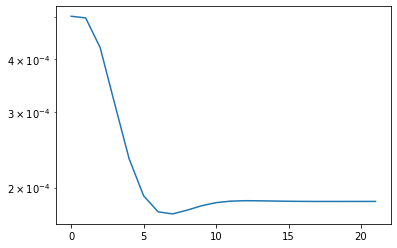

In [198]:
plt.plot(energies)
plt.yscale("log")

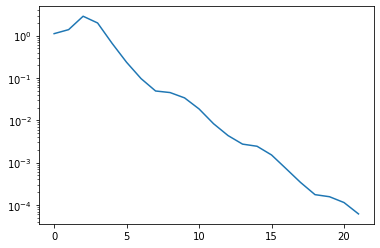

In [199]:
plt.plot(norms)
plt.yscale("log")

# Implementation of the PDHG algorithm

In [210]:
pn1 = 1e-6
epsilon = 1e0
print(f2(grad(u0_mat)))
print(f1np(u0_mat))
print(g(u0_mat))

1.748739225629645e-07
0.00010497897904384499
1.9073484054388313e-06


In [211]:
#constants
L=1
eta = np.amax(p)
mu = 2*np.sqrt(epsilon/(1+L*L)/eta)
tau = mu/2/epsilon
sigma = mu*eta/2
theta = 1/(1+mu)

maxit = 20
tol = 1e-4

In [212]:
def step(uk,vk,wk,uk_bar):
    vk1 = prox_F1np_dual(vk+sigma*uk_bar,sigma)
    wk1 = prox_F2_dual(wk+sigma*grad(uk_bar),sigma)
    uk1 = prox_G(uk-tau*R(vk1)-tau*divergence(wk1),tau)
    uk_bar1 = uk1+theta*(uk1-uk)

    norm = np.linalg.norm(uk1-uk)/np.linalg.norm(uk)
    norm += (np.linalg.norm(vk1-vk)+np.linalg.norm(wk1-wk))/(np.linalg.norm(vk)+np.linalg.norm(wk))
    return uk1,vk1,wk1,uk_bar1,norm

In [213]:
#initialisation
n_iter = 0
uk = gridded_inverse_fourier_transform_nd(kspace_loc, y,
                                                 tuple(grid2D), 'linear')
uk = np.fft.ifft(ynp)
image_rec0 = pysap.Image(data=np.abs(uk))
#image_rec0.show()
#print(ssim(uk,u0_mat))

In [214]:
vk = np.copy(uk)
wk = grad(u0_mat)
uk_bar = np.copy(uk)
norm = 2*tol
norms = []
energies = [energynp(uk)]
ssims = [ssim(uk,u0_mat)]
print("Base ssim:",ssim(uk,u0_mat), "\nBase cost:", energynp(uk))

/home/guillaume/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: ComplexWarning: Casting complex values to real discards the imaginary part
  import sys
/home/guillaume/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: ComplexWarning: Casting complex values to real discards the imaginary part
  if sys.path[0] == '':


Base ssim: 0.6492260834099838 
Base cost: 0.0017381677230068747


In [215]:
while n_iter<50 and norm>tol:
    uk,vk,wk,uk_bar,norm = step(uk,vk,wk,uk_bar)
    n_iter += 1
    ssims.append(ssim(uk,u0_mat))
    norms.append(norm)
    energies.append(energynp(uk))
    print(n_iter," iterations:\nCost:",energynp(uk),"\nssim:",ssim(uk,u0_mat),"\nNorm:",norm,"\n")
print("Final ssim after ",n_iter," iterations:",ssim(uk,u0_mat))

/home/guillaume/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: ComplexWarning: Casting complex values to real discards the imaginary part
  import sys
/home/guillaume/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: ComplexWarning: Casting complex values to real discards the imaginary part
  if sys.path[0] == '':
/home/guillaume/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: ComplexWarning: Casting complex values to real discards the imaginary part
/home/guillaume/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: ComplexWarning: Casting complex values to real discards the imaginary part
/home/guillaume/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: ComplexWarning: Casting complex values to real discards the imaginary part
/home/guillaume/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: ComplexWarning: Casting complex values to real discards the imaginary part
/home/guillaume/anaconda3/lib/pyth

1  iterations:
Cost: 0.0008450711104381319 
ssim: 0.37835701675164596 
Norm: 1.2843824346130917 

2  iterations:
Cost: 0.0007655230730898511 
ssim: 0.28175906429777037 
Norm: 1.903383020820685 

3  iterations:
Cost: 0.0006944437836541169 
ssim: 0.5029835338993189 
Norm: 3.0794663671353493 

4  iterations:
Cost: 0.0005630614752991362 
ssim: 0.6056679090412312 
Norm: 1.5506035360023267 

5  iterations:
Cost: 0.0005146694410270099 
ssim: 0.6823266343590072 
Norm: 1.1188074582413794 

6  iterations:
Cost: 0.0004594384932850145 
ssim: 0.6579569100390501 
Norm: 1.0171085505190034 

7  iterations:
Cost: 0.0004627792612127665 
ssim: 0.6779872026019153 
Norm: 0.9925629593427066 

8  iterations:
Cost: 0.00043894099125023296 
ssim: 0.6312017750537491 
Norm: 1.0043052205457257 

9  iterations:
Cost: 0.00045531095674963373 
ssim: 0.6498839383736965 
Norm: 1.0174615950264247 

10  iterations:
Cost: 0.0004384774510977292 
ssim: 0.6085689955296875 
Norm: 1.0345509700109052 

11  iterations:
Cost: 0.00

KeyboardInterrupt: 

In [219]:
#Final image
image_rec = pysap.Image(data=np.abs(uk))
print(ssim(uk,u0_mat))
image_rec.show()

0.6159663982549429


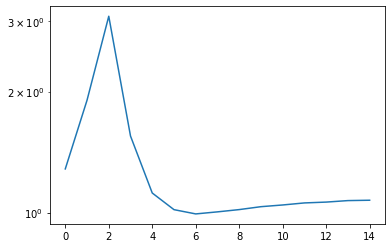

In [217]:
plt.plot(norms)
plt.yscale("log")

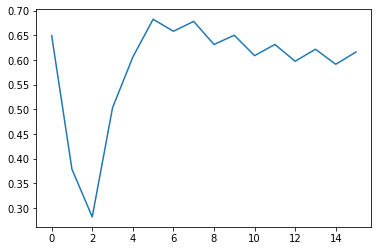

In [218]:
plt.plot(ssims)

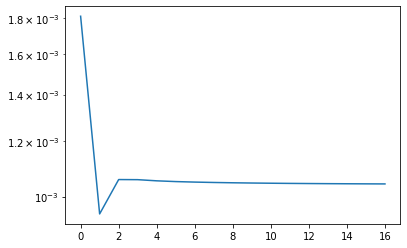

In [121]:
plt.plot(energies)
plt.yscale("log")

In [85]:
print(energynp(u0_mat),energynp(uk))

/home/guillaume/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: ComplexWarning: Casting complex values to real discards the imaginary part
  import sys
/home/guillaume/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: ComplexWarning: Casting complex values to real discards the imaginary part
  if sys.path[0] == '':


0.00014136519254868008 0.001041337361450538
